In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import norm
from tqdm.auto import tqdm

import sys
sys.path.append('../utils')
from utils import *

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
combined_df = retrieve_data()
combined_df.head()

,Date,ROG_Last_Price,ROG_IVOL,CFR_Last_Price,CFR_IVOL,ZURN_Last_Price,ZURN_IVOL,Risk_Free_Rate
0,2023-10-25,237.55,17.6858,107.00,33.0793,426.4,15.7900,1.4594
1,2023-10-26,237.25,17.9504,104.45,33.5406,426.8,15.9736,1.4508
2,2023-10-27,237.75,19.6028,104.40,33.4355,424.4,16.3945,1.4478
3,2023-10-30,241.30,19.3503,104.75,33.1531,428.2,15.9477,1.4623
4,2023-10-31,233.85,19.2518,106.90,32.7788,430.6,15.7948,1.4489


In [3]:
combined_df['Date'].iloc[252]

Timestamp('2024-10-25 00:00:00')

In [4]:
# simulate from 25/7 to end (Dec): future risk-free?

In [4]:
np.random.seed(42)
n_days = 252
dt = 1 / n_days

close = combined_df[['ROG_Last_Price', 'CFR_Last_Price', 'ZURN_Last_Price']]
close.cov()

,ROG_Last_Price,CFR_Last_Price,ZURN_Last_Price
ROG_Last_Price,375.344673,-17.563543,286.937174
CFR_Last_Price,-17.563543,133.176550,138.191785
ZURN_Last_Price,286.937174,138.191785,706.118284


In [5]:
tickers = close.columns
log_returns = np.log((close / close.shift(1)).dropna())
log_returns.iloc[186:, :]

,ROG_Last_Price,CFR_Last_Price,ZURN_Last_Price
187,0.014519,-0.016629,0.000000
188,0.030171,0.027811,0.008811
189,-0.002100,-0.011182,0.000000
190,0.000350,0.006352,0.011422
191,0.001050,-0.001864,-0.002274
...,...,...,...
248,-0.001465,-0.006297,-0.002278
249,-0.002568,0.002366,-0.011084
250,0.018202,-0.007115,-0.001538
251,0.009336,0.018861,0.001923


In [7]:
# Simulating from start
# Assume covariance matrix is constant
# Window sliding: last 90 days

def MultivariateGBMSimulation(
    s0=close.iloc[0], 
    tickers=tickers,
    dt=dt,
    drift=0.01,
    n_paths=100,
    # T=1, # Time horizon in year:
    variance_reduction=None,
    last_id=287,
    current_id=187,
    window_size=30,
    ):

    volatility=log_returns.iloc[(current_id - window_size):current_id, :].cov() * n_days   
    T = dt * (last_id - current_id)
    n_steps = int(T / dt)
    result = np.zeros((len(tickers), n_paths, n_steps))

    if variance_reduction==None:
        for i in tqdm(range(n_paths)):
            choleskyMatrix = np.linalg.cholesky(volatility)
            e = np.random.normal(size=(len(tickers), n_steps)) # Generate RV for steps

            for j in range(n_steps):
                for k in range(len(tickers)):
                    if(j==0):
                        result[k, i, j] = s0[tickers[k]]
                    else:
                        if isinstance(drift, np.ndarray):
                            result[k, i, j] = result[k, i, j-1] * np.exp(
                                (drift[j] -  1/2 * np.sqrt(volatility.iloc[k, k])) * dt + 
                                np.sqrt(dt) * choleskyMatrix[k, k] * e[k, j]) 
                        else:
                            result[k, i, j] = result[k, i, j-1] * np.exp(
                                (drift -  1/2 * np.sqrt(volatility.iloc[k, k])) * dt + 
                                np.sqrt(dt) * choleskyMatrix[k, k] * e[k, j])
                        
    elif variance_reduction=='av':
        for i in tqdm(range(n_paths // 2)):
            choleskyMatrix = np.linalg.cholesky(volatility)
            e = np.random.normal(size=(len(tickers), n_steps)) # Generate RV for steps
            e_tilde = -e    

            for j in range(n_steps):
                for k in range(len(tickers)):
                    if(j==0):
                        result[k, i, j] = s0[tickers[k]]
                        result[k, n_paths - i - 1, j] = s0[tickers[k]]

                    else:
                        if isinstance(drift, np.ndarray):
                            result[k, i, j] = result[k, i, j-1] * np.exp(
                                (drift[j] -  1/2 * np.sqrt(volatility.iloc[k, k])) * dt + 
                                np.sqrt(dt) * choleskyMatrix[k, k] * e[k, j])
                            result[k, n_paths - i - 1, j] = result[k, n_paths - i - 1, j-1] * np.exp(
                                (drift[j] -  1/2 * np.sqrt(volatility.iloc[k, k])) * dt + 
                                np.sqrt(dt) * choleskyMatrix[k, k] * e_tilde[k, j])
                        else:
                            result[k, i, j] = result[k, i, j-1] * np.exp(
                                (drift -  1/2 * np.sqrt(volatility.iloc[k, k])) * dt + 
                                np.sqrt(dt) * choleskyMatrix[k, k] * e[k, j])
                            result[k, n_paths - i - 1, j] = result[k, n_paths - i - 1, j-1] * np.exp(
                                (drift -  1/2 * np.sqrt(volatility.iloc[k, k])) * dt + 
                                np.sqrt(dt) * choleskyMatrix[k, k] * e_tilde[k, j])
                            
    elif variance_reduction=='emc':
        for i in tqdm(range(n_paths)):
            choleskyMatrix = np.linalg.cholesky(volatility)
            e = np.random.normal(size=(len(tickers), n_steps)) # Generate RV for steps

            for j in range(n_steps):
                for k in range(len(tickers)):
                    if(j==0):
                        result[k, i, j] = s0[tickers[k]]
                    else:
                        if isinstance(drift, np.ndarray):
                            result[k, i, j] = result[k, i, j-1] * np.exp(
                                (drift[j] -  1/2 * np.sqrt(volatility.iloc[k, k])) * dt + 
                                np.sqrt(dt) * choleskyMatrix[k, k] * e[k, j])
                        else:
                            result[k, i, j] = result[k, i, j-1] * np.exp(
                                (drift -  1/2 * np.sqrt(volatility.iloc[k, k])) * dt + 
                                np.sqrt(dt) * choleskyMatrix[k, k] * e[k, j])
        for k in range(len(tickers)):  
                # path, step
            correction_factor = result[k][-1, :].mean() / result[k][-1, :] 
            result[k] = result[k] * correction_factor                    
           
    return result, tickers

In [8]:
last_id = 287
backtest_start = 187
backtest_end = 193

prices = []
for current_id in tqdm(range(backtest_start, backtest_end)):
    payoff = []
    result, _ = MultivariateGBMSimulation(s0=close.iloc[current_id], n_paths=1000, variance_reduction='emc', current_id=current_id, window_size=30)
    
    old_path_rog = combined_df['ROG_Last_Price'].iloc[:current_id]
    old_path_cfr = combined_df['CFR_Last_Price'].iloc[:current_id]
    old_path_zurn = combined_df['ZURN_Last_Price'].iloc[:current_id]

    for i in range(result.shape[1]):
        path_rog = np.append(old_path_rog, result[0][i].flatten())
        path_cfr = np.append(old_path_cfr, result[1][i].flatten())
        path_zurn = np.append(old_path_zurn, result[2][i].flatten())

        payoff.append(payoff_func(path_rog, path_cfr, path_zurn, combined_df.iloc[current_id]['Date'], risk_free=0.01, verbose=False))
    
    prices.append(np.mean(payoff))



100%|██████████| 6/6 [00:37<00:00,  6.21s/it]


In [ ]:
prices

In [17]:
combined_df.iloc[backtest_start]['Date'], combined_df.iloc[backtest_end]['Date']

(Timestamp('2024-07-25 00:00:00'), Timestamp('2024-10-25 00:00:00'))

d:\mh4518_simulation_in_fin\notebooks\../utils\utils.py:144: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  real_price['Date'] = pd.to_datetime(real_price['Date'], dayfirst=True)


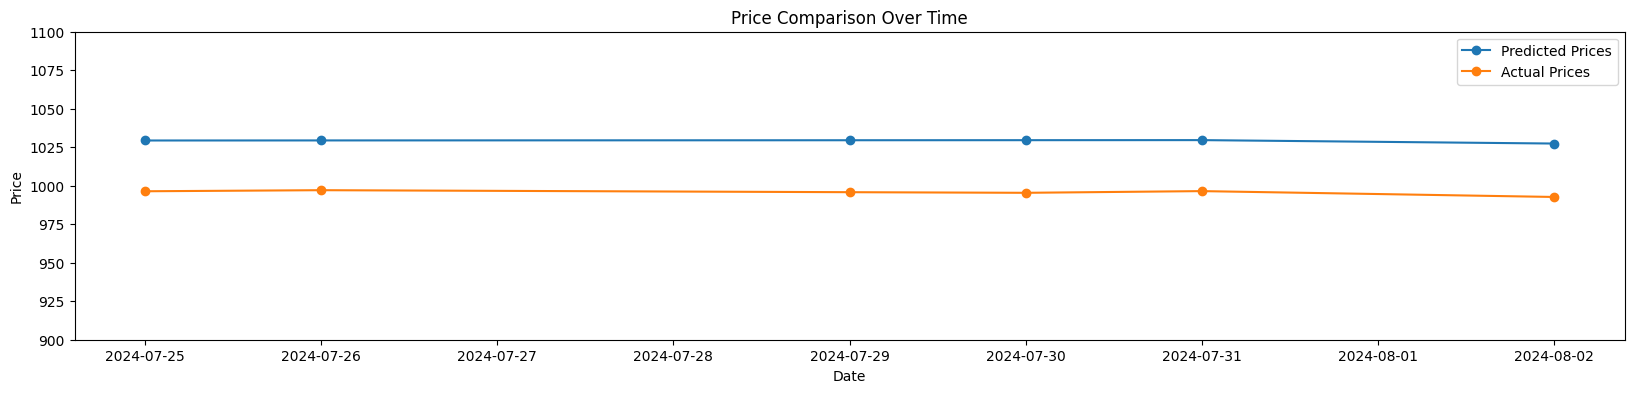

In [11]:
evaluation_plot(
    backtest_start,
    backtest_end,
    combined_df,
    prices
    )

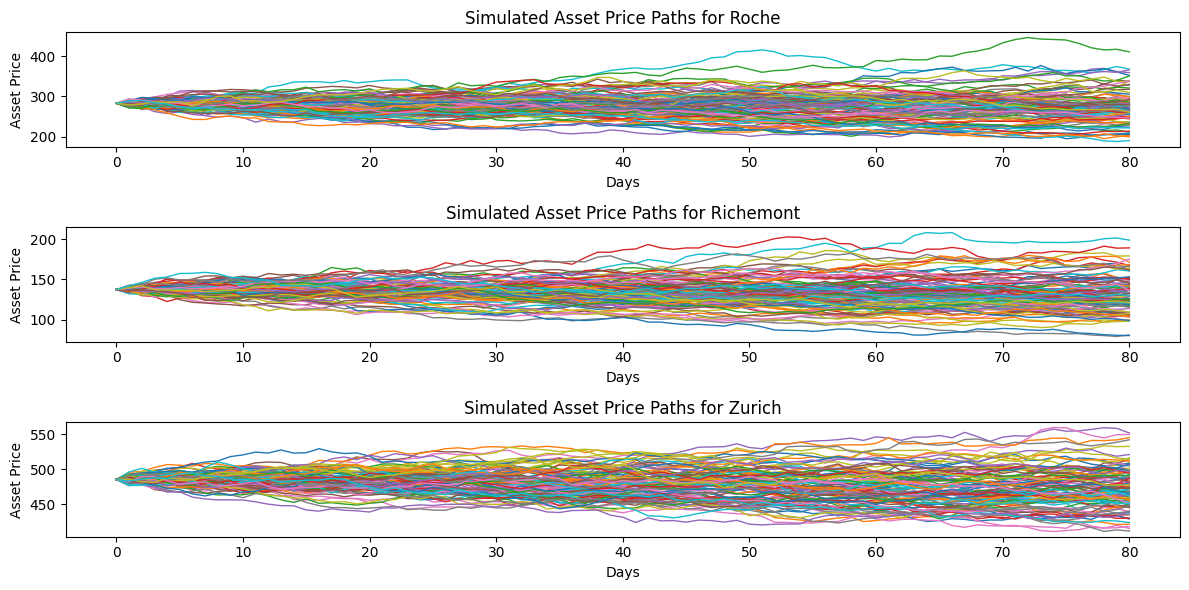

In [13]:
fig, axes = plt.subplots(3, 1, figsize=(12, 6))

for i in range(100):
    axes[0].plot(result[0][i], lw=1)
axes[0].set_title('Simulated Asset Price Paths for Roche')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Asset Price')

for i in range(100):
    axes[1].plot(result[1][i], lw=1)
axes[1].set_title('Simulated Asset Price Paths for Richemont')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Asset Price')

for i in range(100):
    axes[2].plot(result[2][i], lw=1)
axes[2].set_title('Simulated Asset Price Paths for Zurich')
axes[2].set_xlabel('Days')
axes[2].set_ylabel('Asset Price')

plt.tight_layout()
plt.show()

In [ ]:
payoff = []
payoff_av = []
payoff_emc = []

old_path_rog = combined_df['ROG_Last_Price'].iloc[:current_id]
old_path_cfr = combined_df['CFR_Last_Price'].iloc[:current_id]
old_path_zurn = combined_df['ZURN_Last_Price'].iloc[:current_id]

for i in range(result.shape[1]):
    path_rog = np.append(old_path_rog, result[0][i].flatten())
    path_cfr = np.append(old_path_cfr, result[1][i].flatten())
    path_zurn = np.append(old_path_zurn, result[2][i].flatten())

    payoff.append(payoff_func(path_rog, path_cfr, path_zurn))


In [ ]:
np.mean(payoff), np.std(payoff)

(1086.6672018410513, 18.608194826059837)

In [ ]:
neutral_pricing(np.mean(payoff), 0.01, last_id - current_id)

1078.6332864984772